# Combining the 2020 Election Models

Pulling together predictions for the presidential, Senate, House, governor and state legislature races in 2020 to find places that are especially powerful this election cycle. 

In [2]:
import os
import json
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

import models as m

In [33]:
#https://stackoverflow.com/questions/65996797
from importlib import reload
reload(m)

<module 'models' from '/Users/psthomas/Documents/projects/election-meta/models.py'>

# Power sharing model

In [3]:
state_metadata = pd.read_csv('data/state_metadata.csv')
stateleg_metadata = pd.read_csv('data/state_legislature_metadata.csv')
power = m.calculate_seat_power(state_metadata, stateleg_metadata)
power['state_power'].head()

,fips,state_abbr,state_name,governor_power,state_senate_power,state_house_power
0,1,AL,Alabama,0.373499,0.186750,0.186750
1,2,AK,Alaska,0.056350,0.028175,0.028175
2,4,AZ,Arizona,0.548010,0.274005,0.274005
3,5,AR,Arkansas,0.230297,0.115148,0.115148
4,6,CA,California,3.022691,1.511346,1.511346


# Categorical rating conversions

Fivethirtyeight mentions an analysis [here](https://fivethirtyeight.com/features/2018-house-forecast-methodology/) that estimates the average margin of victory for different expert rating categories. I then use these to quantify expert ratings for governor ([Inside Elections](http://www.insideelections.com/ratings/governor)) and state legislatures ([CNalysis](https://www.cnalysiscom.website/)) below.

| Expert Rating | Average margin of victory |
| --- | --- |
| Toss-up | 0 points |
| “Tilts” toward candidate | 4 points |
| “Leans” toward candidate | 7 points |
| “Likely” for candidate | 12 points |
| “Solid” or “safe” for candidate | 34 points |

In [4]:
rating_categories = m.rating_categories
rating_categories

,inside_elections,cnalysis,dem_margin
0,currently-safe-democrat,Safe D,0.34
1,democrat-favored,Likely D,0.12
2,lean-democrat,Lean D,0.07
3,toss-up-tilt-democrat,Tilt D,0.04
4,pure-toss-up,Toss-Up,0.00
5,toss-up-tilt-republican,Tilt R,-0.04
6,lean-republican,Lean R,-0.07
7,republican-favored,Likely R,-0.12
8,currently-safe-republican,Safe R,-0.34


# President

Using the Economist's presidential [model](https://projects.economist.com/us-2020-forecast/president) outputs to calculate the probability of a close election and the tipping point probability by state.

In [5]:
ec = pd.read_csv('data/president/economist_electoral_college_simulations.csv')
ec.head()

,draw,dem_ev,natl_pop_vote,AK,AL,AR,AZ,CA,CO,CT,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,1,396,0.560359,0.4863,0.4098,0.3811,0.5442,0.6735,0.6055,0.6505,...,0.4184,0.4138,0.5098,0.4437,0.5813,0.7142,0.6342,0.5620,0.3669,0.3100
1,2,374,0.552177,0.4745,0.4077,0.4100,0.5094,0.6799,0.5734,0.6078,...,0.4251,0.4508,0.4825,0.4209,0.5687,0.6932,0.6154,0.5631,0.4010,0.3265
2,3,361,0.537326,0.4627,0.4105,0.3601,0.4955,0.6760,0.5507,0.6245,...,0.4033,0.3888,0.5006,0.4082,0.5706,0.6503,0.5885,0.5241,0.3511,0.3065
3,4,388,0.546907,0.4713,0.4171,0.3972,0.5084,0.6820,0.5560,0.6093,...,0.4113,0.4142,0.5036,0.4024,0.5492,0.6597,0.6227,0.5292,0.3575,0.3014
4,5,304,0.518555,0.4103,0.4059,0.3643,0.4609,0.6710,0.5493,0.5785,...,0.3738,0.3815,0.4411,0.3664,0.5408,0.6360,0.5946,0.5059,0.3284,0.3015


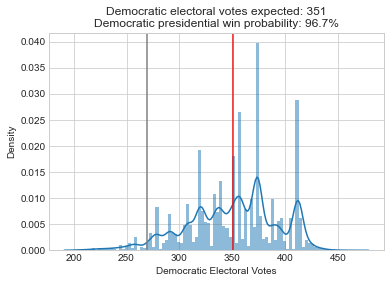

In [20]:
ec_ev_exp = ec['dem_ev'].mean()
ec_dem_win_prob = np.round(((ec['dem_ev'] >= 269).sum()/len(ec))*100, decimals=1)
ec_prob_close = m.normed_prob(ec['dem_ev'], bounds=[0, 538]) #interval=[0.475, 0.525]
ec_title = 'Democratic electoral votes expected: {0}\nDemocratic presidential win probability: {1}%'\
    .format(round(ec_ev_exp), ec_dem_win_prob)
m.plot_histogram(ec['dem_ev'], ec_ev_exp, 269, ec_title, bins=100,
     out='data/output/presidentialhist.png', x_label='Democratic Electoral Votes') #outcome=306 
plt.show()

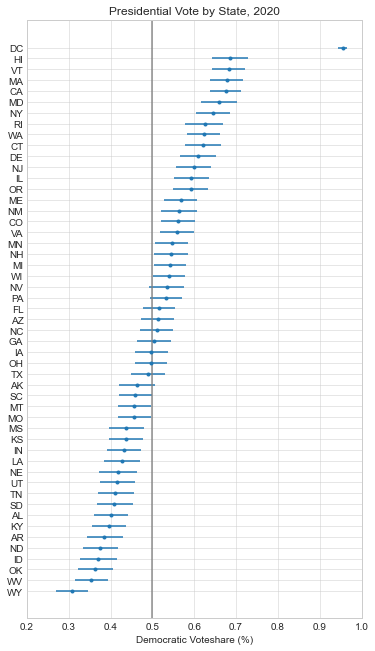

In [41]:
# Note: The Economist forecasts Democratic two party voteshare.
pres_states = pd.read_csv('data/president/economist_state_averages_and_predictions_topline.csv')
pres_states['upper'] = pres_states['projected_vote_high'] - pres_states['projected_vote_mean']
pres_states['lower'] = pres_states['projected_vote_mean'] - pres_states['projected_vote_low']
pres_states = pres_states.sort_values(by='projected_vote_mean', ascending=True).reset_index()
m.seatplot(pres_states, x='projected_vote_mean', x_label='Democratic Voteshare (%)',
    y='state', title='Presidential Vote by State, 2020', out='data/output/presidentialstates.png',
    xlim=[0.2,1.0]) #.png .jpg

In [34]:
pres_tipping_states = m.presidential_tipping_point(ec, state_metadata)
pres_power_df = m.get_presidential_power(pres_tipping_states, power['presidential_power'],
    ec_prob_close, state_metadata)
pres_power_df.head(50)

,state,office,district,potential_power,pr_close,pr_tip,realized_power
13,PA,president,None,25.0,0.049545,0.520245,0.644386
6,MI,president,None,25.0,0.049545,0.113701,0.140832
16,WI,president,None,25.0,0.049545,0.081921,0.101469
0,AZ,president,None,25.0,0.049545,0.057910,0.071728
2,FL,president,None,25.0,0.049545,0.037194,0.046069
3,GA,president,None,25.0,0.049545,0.033427,0.041404
11,NM,president,None,25.0,0.049545,0.030603,0.037905
12,NV,president,None,25.0,0.049545,0.030367,0.037614
8,NC,president,None,25.0,0.049545,0.026601,0.032948
7,MN,president,None,25.0,0.049545,0.024482,0.030324


In [27]:
orig = m.presidential_tipping_point(ec, state_metadata)
orig_power_df = m.get_presidential_power(orig, power['presidential_power'],
    ec_prob_close, state_metadata)
orig_power_df.head(50)

,state,office,district,potential_power,pr_close,pr_tip,realized_power
17,PA,president,None,25.0,0.049545,0.441887,0.547331
4,FL,president,None,25.0,0.049545,0.099725,0.123522
9,MI,president,None,25.0,0.049545,0.094325,0.116833
20,WI,president,None,25.0,0.049545,0.075737,0.093810
1,AZ,president,None,25.0,0.049545,0.044713,0.055382
14,NM,president,None,25.0,0.049545,0.041600,0.051527
10,MN,president,None,25.0,0.049545,0.037450,0.046386
5,GA,president,None,25.0,0.049545,0.035312,0.043739
15,NV,president,None,25.0,0.049545,0.033975,0.042082
11,NC,president,None,25.0,0.049545,0.030625,0.037933


In [36]:
# Only looking at close elections Favors PA, MI, over FL (FL loses 6%, MN, NM 1%)
comp = orig_power_df[['state','pr_tip']].merge(pres_power_df[['state','pr_tip']], on='state')
comp = comp.eval('diff = pr_tip_y - pr_tip_x')
comp.sort_values(by='diff')

,state,pr_tip_x,pr_tip_y,diff
1,FL,0.099725,0.037194,-0.062531
6,MN,0.037450,0.024482,-0.012968
5,NM,0.041600,0.030603,-0.010997
13,CO,0.010225,0.003060,-0.007165
10,TX,0.018425,0.012476,-0.005949
11,VA,0.018288,0.013418,-0.004869
9,NC,0.030625,0.026601,-0.004024
8,NV,0.033975,0.030367,-0.003608
12,NH,0.015075,0.013183,-0.001892
7,GA,0.035312,0.033427,-0.001885


# US Senate

Using Cory McCartan's model [here](https://corymccartan.github.io/projects/senate-20/), which produces results that estimate the tipping probability of each Senate seat. He also includes simulation outputs that I use to calculate the probability of a close election.

In [11]:
with open('data/senate/mccartan_senate.json') as f:
    mc = json.load(f)

mc_df = pd.DataFrame(mc['races'])
mc_df.sort_values(by='tipping_pt', ascending=False).head(5)

,race,race_name,prob,dem_q05,dem_q25,dem_exp,dem_q75,dem_q95,recount,tipping_pt,votes,pr_decisive,rel_voter_power,inc
20,NC,North Carolina,0.642000,0.453443,0.487705,0.514752,0.541062,0.576590,0,0.103499,3634615.75,2.847586e-08,1.171426,-1
3,AZ,Arizona,0.699667,0.453324,0.493806,0.519332,0.545358,0.582011,0,0.092532,2216736.00,4.174242e-08,1.717180,-1
7,GA-S,Georgia-S,0.554667,0.436840,0.478262,0.506092,0.532532,0.573417,0,0.086636,3193538.25,2.712851e-08,1.116000,-1
6,GA,Georgia,0.648667,0.450684,0.488478,0.515698,0.544198,0.582280,0,0.085097,3193538.25,2.664660e-08,1.096175,-1
8,IA,Iowa,0.433000,0.429423,0.466937,0.493605,0.519773,0.559869,0,0.076775,1322429.25,5.805634e-08,2.388294,-1


In [12]:
# hm
# mc_df['tipping_pt'].sum()
# 2.0000003
# mc_df['tipping_pt'] = mc_df['tipping_pt']/2
mc_df['tipping_pt'].sum()

1.0

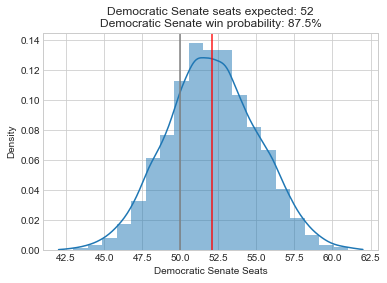

In [13]:
# Load all simulation results
with open('data/senate/mccartan_senate_sim.json') as f:
    mc_sim = json.load(f)
# Add number of Dem wins in each simulation to current
# uncontested control of 35 seats
mc_sim = np.array([sum(x['dem']) + 35 for x in mc_sim])
mc_pr_close = m.normed_prob(mc_sim, bounds=[0,100]) #interval=[0.475, 0.525]
#mc_dem_win = (mc_sim >= 50).sum()/len(mc_sim) #>=50 = 79%, >50 = 69.3
# Just use his probability, it incorporates presidential tie breaker probability
# https://github.com/CoryMcCartan/senate/blob/master/model/forecast.R#L313
mc_dem_win = mc['prob']
mc_dem_seats = np.mean(mc_sim)
mc_title = 'Democratic Senate seats expected: {0}\nDemocratic Senate win probability: {1}%'\
    .format(round(mc_dem_seats), np.round(mc_dem_win*100, 1))
mc_bins = (max(mc_sim)-min(mc_sim) + 1)
m.plot_histogram(mc_sim, mc_dem_seats, 50, mc_title,
    x_label='Democratic Senate Seats', bins=mc_bins,
    out='data/output/senatehist.png')

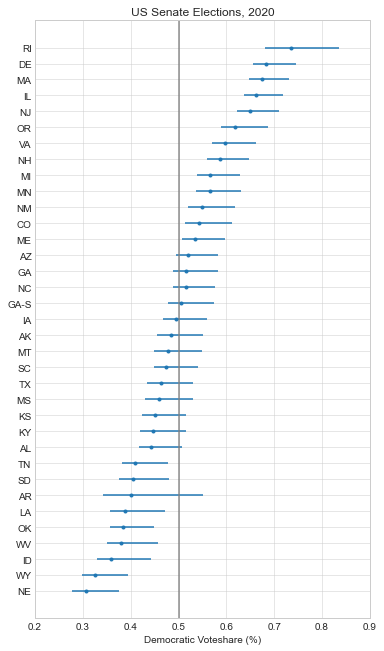

In [7]:
mc_plot = mc_df.copy()
mc_plot['upper'] = mc_plot['dem_q95'] - mc_plot['dem_exp']
mc_plot['lower'] = mc_plot['dem_exp'] - mc_plot['dem_q25']
mc_plot = mc_plot.sort_values(by='dem_exp', ascending=True).reset_index()
m.seatplot(mc_plot, x='dem_exp', x_label='Democratic Voteshare (%)', 
    y='race', title='US Senate Elections, 2020', out='data/output/senateseats.png',
    xlim=[0.2,0.9])

In [8]:
def get_senate_power(mc_df, senate_power, mc_pr_close):
    senate_power_df = mc_df[['race', 'tipping_pt']].copy()
    senate_power_df.rename(
        columns={'race': 'state', 'tipping_pt': 'pr_tip'},
        inplace=True
    )
    senate_power_df['office'] = 'ussenate'
    senate_power_df['potential_power'] = senate_power
    senate_power_df['district'] = senate_power_df['state']
    # Rename GA-S to GA, special senate race from there
    senate_power_df['state'].replace({'GA-S':'GA'}, inplace=True, regex=True)
    senate_power_df['pr_close'] = mc_pr_close
    senate_power_df['realized_power'] = senate_power*mc_pr_close*senate_power_df['pr_tip']
    senate_power_df = senate_power_df[
        ['state', 'office', 'district', 'potential_power', 'pr_close', 'pr_tip', 'realized_power']
    ]
    senate_power_df.sort_values(by='realized_power', ascending=False, inplace=True)
    return senate_power_df

In [9]:
senate_power_df = get_senate_power(mc_df, power['senate_power'], mc_pr_close)
senate_power_df.head(10)

,state,office,district,potential_power,pr_close,pr_tip,realized_power
20,NC,ussenate,NC,12.5,0.491086,0.103499,0.635335
3,AZ,ussenate,AZ,12.5,0.491086,0.092532,0.568014
7,GA,ussenate,GA-S,12.5,0.491086,0.086636,0.531821
6,GA,ussenate,GA,12.5,0.491086,0.085097,0.522374
8,IA,ussenate,IA,12.5,0.491086,0.076775,0.471292
15,ME,ussenate,ME,12.5,0.491086,0.076347,0.468665
4,CO,ussenate,CO,12.5,0.491086,0.061106,0.375106
24,NM,ussenate,NM,12.5,0.491086,0.055010,0.337680
0,AK,ussenate,AK,12.5,0.491086,0.054939,0.337244
28,SC,ussenate,SC,12.5,0.491086,0.048714,0.299034


# US House

Using Inside Election's House seat [ratings](https://insideelections.com/ratings/house) in place of a polling average, which I then sample around using normal distributions.


In [14]:
house_data = pd.read_csv('data/house/inside_elections_house.csv')
house_data = house_data.merge(
    rating_categories[['inside_elections', 'dem_margin']],
    left_on='rating', right_on='inside_elections'
)
house_data['dem'] = 0.50+0.5*house_data['dem_margin']
house_data.head()

,state,district,party,rating,inside_elections,dem_margin,dem
0,AL,1,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.33
1,AL,2,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.33
2,AL,3,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.33
3,AL,4,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.33
4,AL,5,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.33


In [17]:
house_results = m.simulate_house(n=10000, state_uncertainty_sd=0.05, 
    national_uncertainty_sd=0.03, house_data=house_data)
house_summary = pd.DataFrame.from_dict(house_results['summary'])
house_summary

,state,district,mean_vote,q_025,q_975
0,AL,1,0.330217,0.216765,0.442688
1,AL,2,0.329853,0.214141,0.441722
2,AL,3,0.330593,0.216276,0.446045
3,AL,4,0.330192,0.214336,0.446379
4,AL,5,0.329306,0.215612,0.443039
...,...,...,...,...,...
430,OH,1,0.519884,0.406153,0.633952
431,TX,23,0.519298,0.404860,0.633843
432,TX,24,0.520393,0.404577,0.633097
433,UT,4,0.519191,0.403105,0.634162


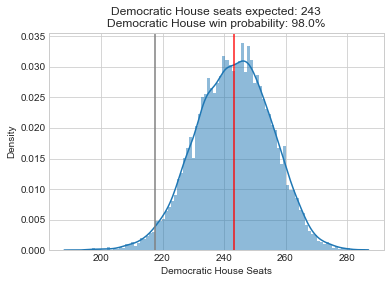

In [19]:
house_sims = np.array(house_results['dem_seats'])
house_mean_seats = house_sims.mean()
house_win_prob = (house_sims >= 218).sum()/len(house_sims)
house_prob_close = m.normed_prob(house_sims, bounds=[0, 435])
house_title = 'Democratic House seats expected: {0}\nDemocratic House win probability: {1}%'\
    .format(round(house_mean_seats), np.round(house_win_prob*100, 1))
m.plot_histogram(house_sims, house_mean_seats, 217.5, house_title, bins=100,
    x_label='Democratic House Seats', out='data/output/househist.png')

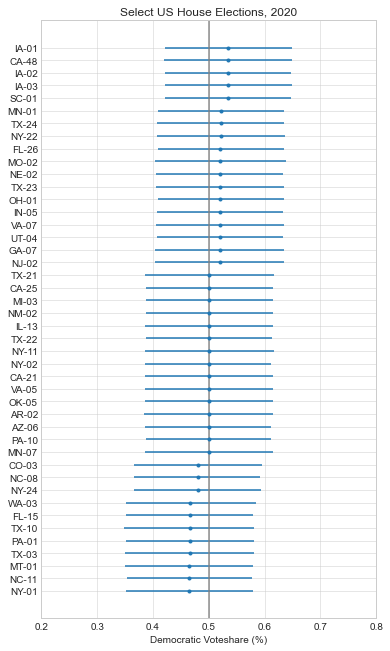

In [57]:
houseplot_df = house_summary.copy()
houseplot_df['upper'] = houseplot_df['q_975'] - houseplot_df['mean_vote']
houseplot_df['lower'] = houseplot_df['mean_vote'] - houseplot_df['q_025']
houseplot_df = houseplot_df[
    (houseplot_df['mean_vote'] > 0.45) &
    (houseplot_df['mean_vote'] < 0.55)
]
houseplot_df['label'] = houseplot_df['state'] + '-' + houseplot_df['district'].astype(str).str.zfill(2)
houseplot_df = houseplot_df.sort_values(by='mean_vote', ascending=True).reset_index()
m.seatplot(houseplot_df, x='mean_vote', y='label', title='Select US House Elections, 2020',
    x_label='Democratic Voteshare (%)', xlim=[0.2, 0.8],
    out='data/output/houseseats.png') #figsize=[6,12.5]

In [63]:
house_power_df = m.get_house_power(house_results, power['house_power'],
    house_prob_close, house_data)
house_power_df.head(10)

,state,office,district,potential_power,pr_close,pr_tip,realized_power
387,NC,ushouse,6,12.5,0.115021,0.0201,0.028899
382,GA,ushouse,6,12.5,0.115021,0.0196,0.028180
383,NV,ushouse,3,12.5,0.115021,0.0191,0.027461
385,NJ,ushouse,7,12.5,0.115021,0.0190,0.027317
384,NH,ushouse,1,12.5,0.115021,0.0184,0.026455
389,TX,ushouse,7,12.5,0.115021,0.0183,0.026311
388,OR,ushouse,4,12.5,0.115021,0.0179,0.025736
381,CA,ushouse,39,12.5,0.115021,0.0176,0.025305
386,NC,ushouse,2,12.5,0.115021,0.0175,0.025161
390,VA,ushouse,2,12.5,0.115021,0.0171,0.024586


# Governors

Use Inside Election's governors [ratings](https://insideelections.com/ratings/governor) as a polling average to sample around. 

In [75]:
gov_data = pd.read_csv('data/governor/inside_elections_gov.csv')
gov_data = gov_data.merge(
    rating_categories[['inside_elections', 'dem_margin']],
    left_on='rating', right_on='inside_elections'
)

gov_data['dem'] = 0.50+0.5*gov_data['dem_margin']
gov_data

,state,party,rating,inside_elections,dem_margin,dem
0,DE,Democrat,currently-safe-democrat,currently-safe-democrat,0.34,0.670
1,WA,Democrat,currently-safe-democrat,currently-safe-democrat,0.34,0.670
2,IN,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.330
3,ND,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.330
4,UT,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.330
5,VT,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.330
6,WV,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.330
7,MO,Republican,lean-republican,lean-republican,-0.07,0.465
8,MT,Democrat,pure-toss-up,pure-toss-up,0.00,0.500
9,NH,Republican,republican-favored,republican-favored,-0.12,0.440


In [76]:
gov_results = m.simulate_governors(n=10000, state_uncertainty_sd=0.05,
    national_uncertainty_sd=0.03, govs=gov_data)
gov_summary = pd.DataFrame.from_dict(gov_results['summary'])
gov_summary

,state,pr_close,mean_vote,q_025,q_975
0,DE,0.006586,0.670598,0.554095,0.785986
1,WA,0.006328,0.670129,0.555090,0.783897
2,IN,0.006661,0.329381,0.211719,0.444215
3,ND,0.004740,0.329002,0.212186,0.441628
4,UT,0.005488,0.329590,0.214568,0.441016
5,VT,0.005648,0.330179,0.217206,0.443495
6,WV,0.005922,0.330248,0.218533,0.444185
7,MO,0.281242,0.465052,0.352410,0.581218
8,MT,0.325824,0.499231,0.384191,0.614794
9,NH,0.205831,0.441067,0.326624,0.554719


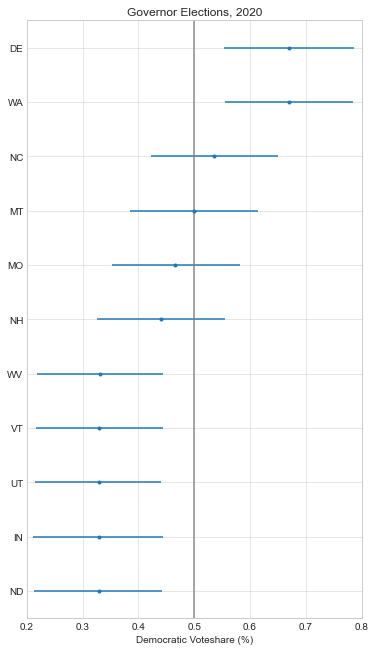

In [78]:
govplot_df = gov_summary.copy()
govplot_df['upper'] = govplot_df['q_975'] - govplot_df['mean_vote']
govplot_df['lower'] = govplot_df['mean_vote'] - govplot_df['q_025']
govplot_df = govplot_df.sort_values(by='mean_vote', ascending=True).reset_index()
m.seatplot(govplot_df, x='mean_vote', y='state', title='Governor Elections, 2020',
    x_label='Democratic Voteshare (%)', out='data/output/govseats.png')

In [81]:
gov_power_df = m.get_governor_power(gov_summary, power['state_power'])
gov_power_df

,state,office,district,potential_power,pr_close,pr_tip,realized_power
10,NC,governor,None,0.793448,0.276450,1,0.219349
7,MO,governor,None,0.468143,0.281242,1,0.131662
8,MT,governor,None,0.081174,0.325824,1,0.026449
9,NH,governor,None,0.103652,0.205831,1,0.021335
1,WA,governor,None,0.575821,0.006328,1,0.003644
2,IN,governor,None,0.511350,0.006661,1,0.003406
4,UT,governor,None,0.241551,0.005488,1,0.001326
6,WV,governor,None,0.137990,0.005922,1,0.000817
0,DE,governor,None,0.073905,0.006586,1,0.000487
3,ND,governor,None,0.058080,0.004740,1,0.000275


# State Legislatures
## State Houses

I'm pulling the state legislature rankings from [CNalysis](https://www.cnalysiscom.website/) instead of modeling individual seats in each legislature. I convert the categorical ratings into expected seat margins, then sample around those seat margins using the polling uncertainties I use above (state_sd = 0.05, national_sd = 0.03), scaled to match the number of seats in each legislature. I then sample from normal distributions around the projected seat margins to find win probabilities and probabilities of close elections. This isn't very sophisticated, but it's better than nothing.

In [89]:
sh = m.prep_statehouse_data('data/statehouse/cnalysis_shodds.csv',
    rating_categories, stateleg_metadata)
sh.head()

,state,rating,cnalysis,dem_margin,state_abbr,house_num,dem
0,AK,Tilt R,Tilt R,-0.04,AK,40.0,19.20
1,NC,Tilt R,Tilt R,-0.04,NC,120.0,57.60
2,PA,Tilt R,Tilt R,-0.04,PA,203.0,97.44
3,AZ,Lean D,Lean D,0.07,AZ,60.0,32.10
4,AR,Safe R,Safe R,-0.34,AR,100.0,33.00


In [92]:
statehouse_results = m.simulate_statehouses(n=10000, state_uncertainty_sd=0.05,
    national_uncertainty_sd=0.03, house_data=sh)

In [96]:
statehouse_summary = pd.DataFrame(statehouse_results['summary'])
statehouse_summary.sort_values(by='pr_close', ascending=False)
statehouse_summary.reset_index(drop=True, inplace=True)
statehouse_summary.head()

,state,pr_close,mean_seats,q_025,q_975
0,AK,0.308690,19.1981,15.0,24.0
1,NC,0.308957,57.6320,44.0,71.0
2,PA,0.312558,97.4892,74.0,121.0
3,AZ,0.275901,32.0247,25.0,39.0
4,AR,0.005573,32.9877,22.0,44.0


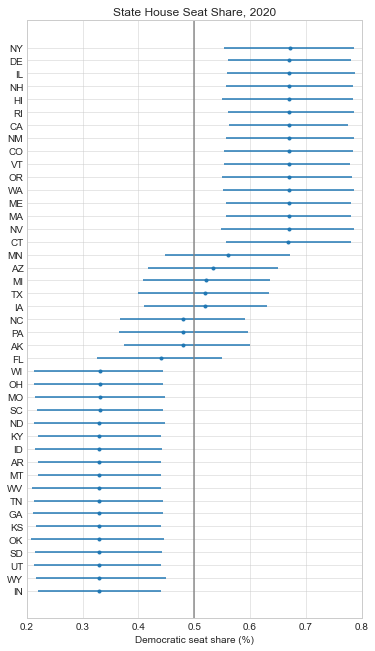

In [97]:
statehouse_plot = statehouse_summary.copy()
statehouse_plot = statehouse_plot.merge(
    stateleg_metadata[['state_abbr', 'house_num']],
    left_on='state', right_on='state_abbr'
)
#statehouse_plot.set_index('state', inplace=True)
# https://stackoverflow.com/questions/34540567
statehouse_plot[['mean_seats', 'q_025', 'q_975']] = statehouse_plot[['mean_seats', 'q_025', 'q_975']] \
    .div(statehouse_plot['house_num'], axis=0)
statehouse_plot['lower'] = statehouse_plot['mean_seats']-statehouse_plot['q_025']
statehouse_plot['upper'] = statehouse_plot['q_975']-statehouse_plot['mean_seats']
statehouse_plot.sort_values(by='mean_seats', ascending=True, inplace=True)
statehouse_plot.reset_index(drop=True, inplace=True)

m.seatplot(statehouse_plot, x='mean_seats', y='state', title='State House Seat Share, 2020', 
         x_label='Democratic seat share (%)', out='data/output/statehouseseats.png')

In [100]:
statehouse_power_df = m.get_statehouse_power(statehouse_summary, power['state_power'])
statehouse_power_df.head()

,state,office,district,potential_power,pr_close,pr_tip,realized_power
41,TX,statehouse,None,1.096604,0.310268,1,0.340242
38,FL,statehouse,None,0.813778,0.203328,1,0.165464
2,PA,statehouse,None,0.489316,0.312558,1,0.152940
1,NC,statehouse,None,0.396724,0.308957,1,0.122571
40,MI,statehouse,None,0.381911,0.312953,1,0.119520


# State Senates

Take same approach as with state houses above, getting the state senate ratings from CNalysis again.

In [110]:
ss = m.prep_statesenate_data('data/statesenate/cnalysis_ssodds.csv',
    rating_categories, stateleg_metadata)
ss.head()

,state,rating,cnalysis,dem_margin,state_abbr,senate_num,dem
0,AK,Safe R,Safe R,-0.34,AK,20,6.60
20,WI,Safe R,Safe R,-0.34,WI,33,10.89
19,UT,Safe R,Safe R,-0.34,UT,29,9.57
18,TX,Safe R,Safe R,-0.34,TX,31,10.23
17,TN,Safe R,Safe R,-0.34,TN,33,10.89


In [111]:
statesenate_results = m.simulate_statesenates(n=10000, state_uncertainty_sd=0.05,
    national_uncertainty_sd=0.03, senate_data=ss)

In [112]:
statesenate_summary = pd.DataFrame(statesenate_results['summary'])
statesenate_summary.sort_values(by='pr_close', ascending=False).head()

,state,pr_close,mean_seats,q_025,q_975
24,NC,0.308703,23.9990,18.0,30.0
27,MN,0.271653,35.7553,28.0,43.0
23,WV,0.262112,15.7872,12.0,20.0
26,AZ,0.255161,16.0185,13.0,19.0
25,NH,0.252461,12.8210,10.0,16.0


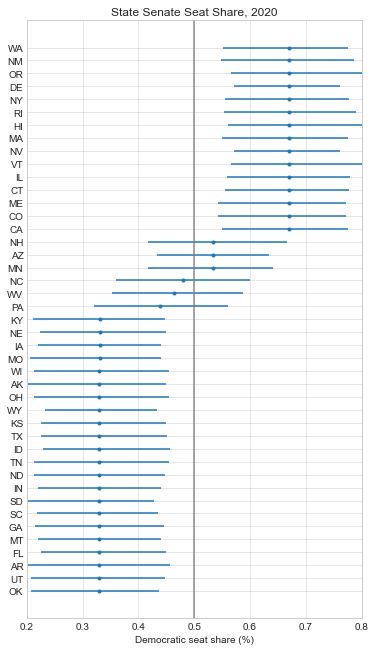

In [114]:
statesenate_plot = statesenate_summary.copy()
statesenate_plot = statesenate_plot.merge(
    stateleg_metadata[['state_abbr', 'senate_num']],
    left_on='state', right_on='state_abbr'
)
# https://stackoverflow.com/questions/34540567
statesenate_plot[['mean_seats', 'q_025', 'q_975']] = statesenate_plot[['mean_seats', 'q_025', 'q_975']] \
    .div(statesenate_plot['senate_num'], axis=0)
statesenate_plot['lower'] = statesenate_plot['mean_seats']-statesenate_plot['q_025']
statesenate_plot['upper'] = statesenate_plot['q_975']-statesenate_plot['mean_seats']
statesenate_plot.sort_values(by='mean_seats', ascending=True, inplace=True)
statesenate_plot.reset_index(drop=True, inplace=True)
m.seatplot(statesenate_plot, x='mean_seats', y='state',
    title='State Senate Seat Share, 2020',
    x_label='Democratic seat share (%)', out='statesenateseats.png')

In [117]:
statesenate_power_df = m.get_statesenate_power(statesenate_summary, power['state_power'])
statesenate_power_df.head()

,state,office,district,potential_power,pr_close,pr_tip,realized_power
24,NC,statesenate,None,0.396724,0.308703,1,0.122470
22,PA,statesenate,None,0.489316,0.195848,1,0.095832
26,AZ,statesenate,None,0.274005,0.255161,1,0.069915
27,MN,statesenate,None,0.214385,0.271653,1,0.058238
23,WV,statesenate,None,0.068995,0.262112,1,0.018084


# Cumulative Values

Concatenate all the power values together, and calculate summary statistics.

In [2]:
today = datetime.date.today()

cumulative_df = pd.concat([pres_power_df, senate_power_df, house_power_df,
    gov_power_df, statehouse_power_df, statesenate_power_df])
cumulative_df = cumulative_df.sort_values(by='realized_power', ascending=False)
# cumulative_df.to_csv('data/output/seat_realized_power.csv', index=False)
# cumulative_df.to_csv('data/archive/seat_realized_power_{}.csv'.format(today), index=False)
cumulative_df.head(15)
# TODO: Should office_power be left out? These values aren't unique to each
# measurement, while the realized_power values are.

NameError: name 'datetime' is not defined

In [1]:
# 'office_power':'mean',
cumulative_df.groupby(by='office') \
    .agg({'realized_power':'sum'}) \
    .sort_values(by='realized_power', ascending=False) \
    .head(10)

NameError: name 'cumulative_df' is not defined

In [45]:
matrix = cumulative_df.groupby(by=['state', 'office']).agg({'realized_power': 'sum'})
matrix = matrix.pivot_table(index='state', columns='office', values='realized_power')
matrix['sum'] = matrix.sum(axis=1)
matrix.sort_values(by='sum', ascending=False, inplace=True)
matrix.fillna(0, inplace=True)
matrix = matrix[['governor', 'statehouse', 'statesenate',
    'president', 'ushouse', 'ussenate', 'sum']]
matrix=matrix*100
matrix.to_csv('data/output/statescore-matrix.csv', index=True)

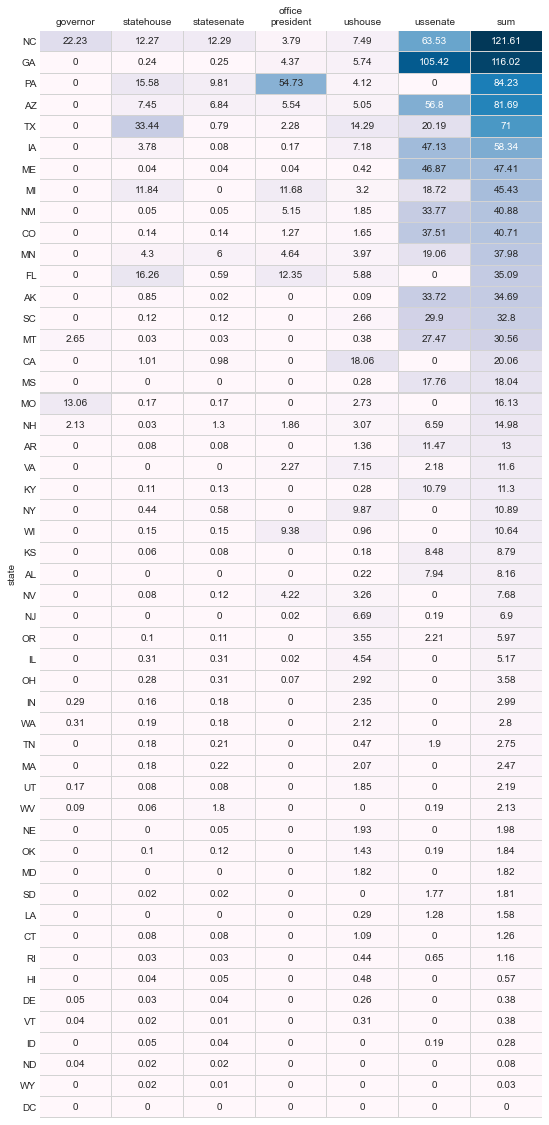

In [46]:
#http://seaborn.pydata.org/generated/seaborn.heatmap.html
fig, ax = plt.subplots(figsize=[9, 20]) #[7, 20] [20, 7] .T edgecolor='gray'
heatmap = sns.heatmap(np.around(matrix, decimals=2) , ax=ax, annot=True,fmt='g', linewidths=0.01, linecolor='lightgray',
    cbar=False, cmap='PuBu') #cmap="YlOrRd"  viridis 'cividis' YlGnBu Blues  best: OrRd PuBu
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
loc, labels = plt.yticks()
heatmap.set_yticklabels(labels, rotation=0)
# for _, spine in heatmap.spines.items():
#     spine.set_visible(True)
plt.savefig('heatmap.png', bbox_inches='tight')
heatmap
# Make this, with state legislatures, except in d3.js
# then allow people to set the weights, then show a transition where
# the states change position.
# Then include the individual histograms and seat distributions w/uncertainty as well.

In [49]:
#Careful running, as output now contains evaluation as well
#!cp -vr data/output/ ~/Documents/projects/pstblog/psthomas.github.io/images/elections-meta/

In [125]:
# Combine all estimated results with uncertainty
pres_est = pres_states.copy()
pres_est = pres_est[['state', 'projected_vote_mean',
        'projected_vote_low', 'projected_vote_high']]
pres_est['body'] = 'president'
pres_est['id'] = pres_est['state']
pres_est['measure'] = 'dem two party voteshare'
pres_est = pres_est.rename(columns={'projected_vote_mean':'value', 
    'projected_vote_low':'low', 'projected_vote_high':'high'})

senate_est = mc_df.copy()
senate_est = senate_est[['race', 'dem_exp', 'dem_q05', 'dem_q95']]
senate_est = senate_est.rename(columns={'race':'id', 'dem_exp':'value',
    'dem_q05':'low', 'dem_q95':'high'})
senate_est['state'] = senate_est['id'].str[:2]
senate_est['measure'] = 'dem two party voteshare'
senate_est['body'] = 'ussenate'

house_est = house_summary.copy()
house_est['district'] =  house_est['district'].astype('str')
house_est['id'] = house_est['state'] + '-' + house_est['district'].str.zfill(2)
house_est = house_est.rename(columns={'mean_vote':'value',
    'q_025':'low', 'q_975':'high'})
house_est['body'] = 'ushouse'
house_est['measure'] = 'dem two party voteshare'
del house_est['district']

gov_est = gov_summary.copy()
gov_est['id'] = gov_est['state']
gov_est = gov_est.rename(columns={'mean_vote': 'value',
    'q_025':'low', 'q_975': 'high'})
gov_est['body'] = 'governor'
gov_est['measure'] = 'dem two party voteshare'
del gov_est['pr_close']

# Dem percent seatshare calculated for statehouse_plot
statehouse_est = statehouse_plot.copy()
statehouse_est = statehouse_est.rename(columns={
    'mean_seats':'value', 'q_025': 'low', 'q_975': 'high'
})
statehouse_est = statehouse_est[['state', 'value', 'low', 'high']]
statehouse_est['id'] =  statehouse_est['state']
statehouse_est['body'] = 'statehouse'
statehouse_est['measure'] = 'dem two party seat share'

statesenate_est = statesenate_plot.copy()
statesenate_est = statesenate_est.rename(columns={
    'mean_seats':'value', 'q_025': 'low', 'q_975': 'high'
})
statesenate_est = statesenate_est[['state', 'value', 'low', 'high']]
statesenate_est['id'] =  statesenate_est['state']
statesenate_est['body'] = 'statesenate'
statesenate_est['measure'] = 'dem two party seat share'

projected_results = pd.concat([pres_est, senate_est, house_est,
    gov_est, statehouse_est, statesenate_est])
projected_results.to_csv('data/output/projected_results.csv', index=False,
    columns=['state', 'body', 'id', 'measure', 'value', 'low', 'high'])
projected_results

,state,value,low,high,body,id,measure
0,WY,0.307423,0.269915,0.346847,president,WY,dem two party voteshare
1,WV,0.354434,0.315643,0.394822,president,WV,dem two party voteshare
2,OK,0.363814,0.322586,0.406572,president,OK,dem two party voteshare
3,ID,0.369899,0.327096,0.414542,president,ID,dem two party voteshare
4,ND,0.374696,0.333556,0.417334,president,ND,dem two party voteshare
...,...,...,...,...,...,...,...
38,NY,0.669897,0.555556,0.777778,statesenate,NY,dem two party seat share
39,DE,0.670205,0.571429,0.761905,statesenate,DE,dem two party seat share
40,OR,0.670340,0.566667,0.800000,statesenate,OR,dem two party seat share
41,NM,0.670412,0.547619,0.785714,statesenate,NM,dem two party seat share


# Evaluation

Adding the actual outcomes to the histograms for evaluation purposes.

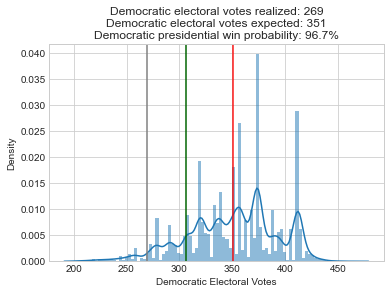

In [21]:
m.plot_histogram(ec['dem_ev'], ec_ev_exp, 269,
    'Democratic electoral votes realized: 269\n' + ec_title, bins=100,
    out='data/output/evaluation/presidentialhist.png', x_label='Democratic Electoral Votes', outcome=306)

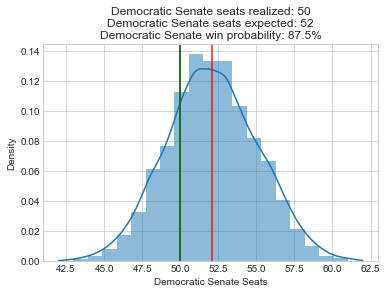

In [22]:
m.plot_histogram(mc_sim, mc_dem_seats, 50,
    'Democratic Senate seats realized: 50\n'+mc_title,
    x_label='Democratic Senate Seats', bins=mc_bins,
    out='data/output/evaluation/senatehist.png', outcome=50)

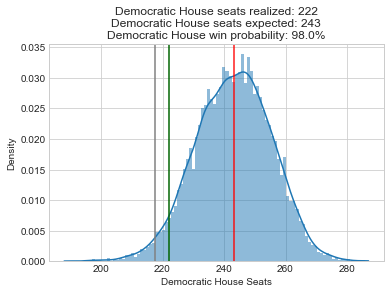

In [23]:
m.plot_histogram(house_sims, house_mean_seats, 217.5,
    'Democratic House seats realized: 222\n' + house_title,
    x_label='Democratic House Seats', bins=100,
    out='data/output/evaluation/househist.png', outcome=222)